In [1]:
import pandas as pd
pd.set_option('display.max_columns',50)
from IPython.display import HTML
import numpy as np

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

# from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier,plot_importance

from sklearn.metrics import accuracy_score,classification_report

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
train_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [5]:
train_df.dtypes.to_frame()

,0
Loan_ID,object
Gender,object
Married,object
Dependents,object
Education,object
Self_Employed,object
ApplicantIncome,int64
CoapplicantIncome,float64
LoanAmount,float64
Loan_Amount_Term,float64


In [6]:
num_col = train_df.columns[(train_df.dtypes=='float') | (train_df.dtypes=='int')]
num_col

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

In [7]:
cat_feats = train_df.columns[train_df.dtypes=='object']
cat_feats

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')

#### Checking any null values exists in the dataframe

In [8]:
train_df.shape

(614, 13)

In [9]:
train_df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [10]:
missing_col= train_df.columns[train_df.isnull().any()]
missing_col

Index(['Gender', 'Married', 'Dependents', 'Self_Employed', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

In [ ]:
# Missing values imputation

# train_df['Gender'] = train_df['Gender'].astype(str).fillna(train_df['Gender'].mode())
# train_df['Married'] = train_df['Married'].astype(str).fillna(train_df['Married'].mode())
# train_df['Dependents'] = train_df['Dependents'].astype(str).fillna(train_df['Dependents'])
# train_df['Self_Employed'] = train_df['Self_Employed'].astype(str).fillna(train_df['Self_Employed'].mode())
# train_df['LoanAmount'] = train_df['LoanAmount'].fillna(train_df['LoanAmount'].mean())
# train_df['Loan_Amount_Term'] = train_df['Loan_Amount_Term'].fillna(train_df['Loan_Amount_Term'].mean())
# train_df['Credit_History'] = train_df['Credit_History'].fillna(train_df['Credit_History'].mean())




In [11]:
def handle_na(dataframe):
    for c in missing_col:
        if c in list(set(dataframe.columns[dataframe.dtypes=='object'])):
            dataframe[c] = dataframe.loc[:,c].astype(str).fillna(dataframe.loc[:,c].mode())
        else: 
            dataframe.loc[:,c] = dataframe.loc[:,c].fillna(dataframe.loc[:,c].mean())


In [12]:
handle_na(train_df)

In [13]:
train_df.isnull().sum().to_frame()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


In [14]:
test_df.isnull().sum().to_frame()

,0
Loan_ID,0
Gender,11
Married,0
Dependents,10
Education,0
Self_Employed,23
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,5
Loan_Amount_Term,6


In [15]:
handle_na(test_df)

In [ ]:
# Now Identity for presence of Outlier in datasets

"""
Z score is an important concept in statistics. Z score is also called standard score. This score helps to understand 
if a data value is greater or smaller than mean and how far away it is from the mean. More specifically, Z score tells 
how many standard deviations away a data point is from the mean.

Z score = (x -mean) / std. deviation



A normal distribution is shown below and it is estimated that
68% of the data points lie between +/- 1 standard deviation.
95% of the data points lie between +/- 2 standard deviation
99.7% of the data points lie between +/- 3 standard deviation




"""

from IPython.display import Image
Image(filename='z_score.png')



In [16]:
for i in train_df[num_col]:
    outlier= []
    col_mean = train_df[i].mean()
    std_dev = np.std(train_df[i])
    z = (train_df[i]-col_mean)/std_dev
    if (z > col_mean).any():
        outlier.append(i)        
    print("mean of {} is {} and standard Deviation is {} ".format(i, col_mean,std_dev))
    
    print("outlier in {}".format(i), outlier)
    
    

mean of ApplicantIncome is 5403.459283387622 and standard Deviation is 6104.0648565338915 
outlier in ApplicantIncome []
mean of CoapplicantIncome is 1621.2457980271008 and standard Deviation is 2923.8644597700595 
outlier in CoapplicantIncome []
mean of LoanAmount is 146.41216216216216 and standard Deviation is 83.9690053763677 
outlier in LoanAmount []
mean of Loan_Amount_Term is 342.0 and standard Deviation is 64.32004667215965 
outlier in Loan_Amount_Term []
mean of Credit_History is 0.8421985815602836 and standard Deviation is 0.3493961141146428 
outlier in Credit_History []


In [17]:
#dropping loan_id from train_df and test_df
train_df = train_df.drop('Loan_ID',axis=1)
loan_ids = test_df['Loan_ID'].values
test_df = test_df.drop('Loan_ID',axis=1)

In [18]:
train_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


In [20]:
(train_df["Loan_Status"].value_counts()/train_df.shape[0])*100

Y    68.729642
N    31.270358
Name: Loan_Status, dtype: float64

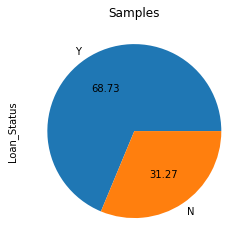

In [26]:
ax = train_df["Loan_Status"].value_counts().plot.pie(autopct='%.2f').set_title("Samples")
plt.savefig("../img/Samples.png", bbox_inches="tight")

In [ ]:
# categorical_features_indices = np.where(train_df.dtypes != np.float)[0]

# categorical_features_indices

In [ ]:
# train_df.iloc[:,[0,1,2,3,4,10]].head()

### Convert to X and Y

In [ ]:
X_train, Y = train_df.drop(["Loan_Status"], axis=1).values, train_df["Loan_Status"].values
X_test = test_df.values

X_train.shape, Y.shape, X_test.shape

### Perform validation

In [ ]:
kfold, scores = KFold(n_splits=5, shuffle=True,random_state=0) , list()
for train,test in kfold.split(X_train):
    x_train,x_test = X_train[train], X_train[test]
    y_train, y_test = Y[train],Y[test]
    
    model = CatBoostClassifier(random_state=27,max_depth=4,task_type='CPU',devices='0:1',n_estimators=1000,verbose=True)
    model.fit(x_train,y_train,cat_features = [0,1,2,3,4,10])
    preds = model.predict(x_test)
    score = f1_score(y_test,preds,average='weighted')
    scores.append(score)
    print(score)
print("Average: ",sum(scores)/len(scores))
    

### Make final prediction using Catboost

In [ ]:
model = CatBoostClassifier(random_state=27, task_type="GPU", devices="0:1", n_estimators=1000, max_depth=4, verbose=500)
model.fit(X_train,Y,cat_features = [0,1,2,3,4,10] )
preds1 = model.predict(X_test)

### Check Feature Importance

In [ ]:
feat_imp = pd.Series(model.feature_importances_,index = train_df.drop('Loan_Status',axis=1).columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

## XGBoost

### Pre-Processing specific to LightGBM

In [ ]:
train_df_1 = train_df.copy()
test_df_1 = test_df.copy()

In [ ]:
le = LabelEncoder()

train_df_1['Gender'] = le.fit_transform(train_df_1['Gender'])
test_df_1['Gender'] = le.fit_transform(test_df_1['Gender'])

train_df_1['Married'] = le.fit_transform(train_df_1['Married'])
test_df_1['Married'] = le.fit_transform(test_df_1['Married'])


train_df_1['Married'] = le.fit_transform(train_df_1['Married'])
test_df_1['Married'] = le.fit_transform(test_df_1['Married'])

train_df_1['Education'] = le.fit_transform(train_df_1['Education'])
test_df_1['Education'] = le.fit_transform(test_df_1['Education'])

train_df_1['Self_Employed'] = le.fit_transform(train_df_1['Self_Employed'])
test_df_1['Self_Employed'] = le.fit_transform(test_df_1['Self_Employed'])

train_df_1['Property_Area'] = le.fit_transform(train_df_1['Property_Area'])
test_df_1['Property_Area'] = le.fit_transform(test_df_1['Property_Area'])



train_df_1['Dependents']= le.fit_transform(train_df_1['Dependents'])
test_df_1['Dependents']= le.fit_transform(test_df_1['Dependents'])


train_df_1['Loan_Status']= le.fit_transform(train_df_1['Loan_Status'])

### Convert to X and Y

In [ ]:
X_train, Y = train_df_1.drop(["Loan_Status"], axis=1).values, train_df_1["Loan_Status"].values
X_test = test_df_1.values

X_train.shape, Y.shape, X_test.shape

In [ ]:
import xgboost as xgb

In [ ]:
param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

In [ ]:
kfold, scores = KFold(n_splits=15, shuffle=True,random_state=0) , list()
for train,test in kfold.split(X_train):
    x_train,x_test = X_train[train], X_train[test]
    y_train, y_test = Y[train],Y[test]
    
    model = XGBClassifier()
    model.fit(x_train,y_train)
    preds1 = model.predict(x_test)
    print('Accuracy of Model is : ',accuracy_score(y_test,preds1))
    score = f1_score(y_test,preds1,average='weighted')
    scores.append(score)
    print(score)
print("Average: ",sum(scores)/len(scores))
    
    
    

### Making a final Prediction using Xgboost

In [ ]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=7, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
model.fit(X_train,Y)
prediction = model.predict(X_test)

In [ ]:
submission_df = pd.read_csv('sample_submission_49d68Cx.csv')
submission_df['Probability'] = preds1

In [ ]:
del submission_df['Loan_Status']

In [ ]:
# Yes =1 ; Loan = 0

In [ ]:
submission_df['Loan_Status'] = ['Y' if x==1 else 'N' for x in submission_df['Probability']]

In [ ]:
submission_df.head()

In [ ]:
del submission_df['Probability']
submission_df.to_csv('Xgb_Prediction.csv',index=False)